In [1]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'Fashion', 'ECG_2', 'Train1'
Gdrive = '/content/drive/MyDrive/ColabNotebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb

In [4]:
!pip install dcor dtaidistance
import dcor
from dtaidistance import dtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.9 MB/s eta 0:00:00


In [5]:
import h5py
from torch.utils.data import Dataset

class ECG(Dataset):
    def __init__(self, train=True):
        if train:
            with h5py.File(os.path.join(Gdrive, 'data/train_ecg.hdf5'), 'r') as hdf:
                self.x, self.y = hdf['x_train'][:], hdf['y_train'][:]
        else:
            with h5py.File(os.path.join(Gdrive, 'data/test_ecg.hdf5'), 'r') as hdf:
                self.x, self.y = hdf['x_test'][:], hdf['y_test'][:]

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

In [6]:
dataset, testset = ECG(True), ECG(False)

In [7]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

#Accuracy

In [8]:
class ECG_2(nn.Module):
  def __init__(self, in_channels, num_classes, dropout=(0.2,0.3)):
    super().__init__()
    self.client = nn.Sequential(
        nn.Conv1d(1, 16, 7, padding=3), nn.LeakyReLU(), nn.MaxPool1d(2),
        nn.Conv1d(16, 16, 5, padding=2), nn.LeakyReLU(), nn.MaxPool1d(2)
    )
    self.server = nn.Sequential(
        nn.Flatten(),
        nn.Linear(16*32, 128), nn.LeakyReLU(),
        nn.Linear(128, 5), nn.LogSoftmax(dim=1)
    )

In [ ]:
# sequential training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'sequence').clients, 'IID-Seq')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/<class 'torch.utils.data.dataset.Dataset'>-ECG_2-Train1-6-IID-Seq.acc


In [ ]:
# private training
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private').clients, 'IID-Prv')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/<class 'torch.utils.data.dataset.Dataset'>-ECG_2-Train1-6-IID-Prv.acc


In [ ]:
caches = [4 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', caches=caches).clients, 'IID-Prv')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/<class 'torch.utils.data.dataset.Dataset'>-ECG_2-Train1-6-IID-Prv.acc


In [ ]:
caches = [2 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', caches=caches).clients, 'IID-Prv')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/<class 'torch.utils.data.dataset.Dataset'>-ECG_2-Train1-6-IID-Prv.acc


In [ ]:
caches = [8 for i in range(num_clients)]
saveAccuracies(Gdrive, train_splitnn(clients, (testset), 'private', caches=caches).clients, 'IID-Prv')

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

/content/drive/MyDrive/ColabNotebooks/SplitLearning3/data/<class 'torch.utils.data.dataset.Dataset'>-ECG_2-Train1-6-IID-Prv.acc


In [ ]:
train_splitnn(clients, (testset), 'sequence', 400)

  0%|          | 0/400 [00:00<?, ?it/s]

Output()

In [ ]:
train_splitnn(clients, (testset), 'private', 400)

  0%|          | 0/400 [00:00<?, ?it/s]

Output()

In [ ]:
train_splitnn(clients, (testset), 'private', 400, caches=[4 for i in range(num_clients)])

  0%|          | 0/400 [00:00<?, ?it/s]

Output()

#Leakage

In [9]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose1d(16, 16, 7, 2, 3, 1), nn.ReLU(),
      nn.ConvTranspose1d(16, 1, 5, 2, 2, 1), nn.Sigmoid()
    )
  def forward(self, x):
    return self.model(x)

In [ ]:
network = train_splitnn(clients, (testset), 'sequence', 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

In [10]:
def reconstruct(decoders):
    image = next(iter(DataLoader(testset)))[0]
    plt.plot(image[0,0])
    plt.figure(figsize=(32,8))
    for i in range(num_clients):
        plt.subplot(1, num_clients, i+1)
        with torch.no_grad():
            network.clients[i].eval(), decoders[i].eval()
            output = decoders[i](network.clients[i](image.cuda()))
        plt.plot(output.cpu()[0,0])
        plt.title('dtw:{:.4}, cor:{:.4}, {:.0e}'.format(dtw.distance_fast(image[0,0].numpy().astype(np.double), output[0,0].cpu().numpy().astype(np.double)),\
                                             dcor.distance_correlation(image[0,0], output[0,0].cpu()), F.mse_loss(image, output.cpu())))

#reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

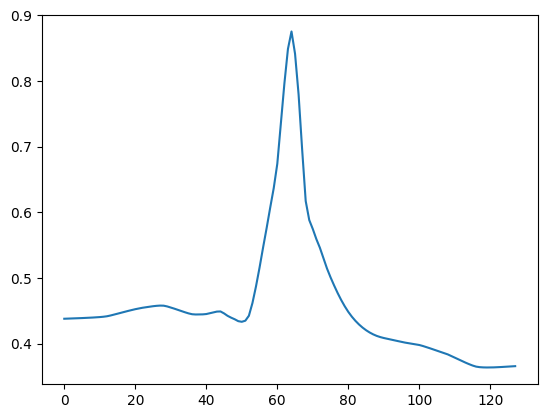

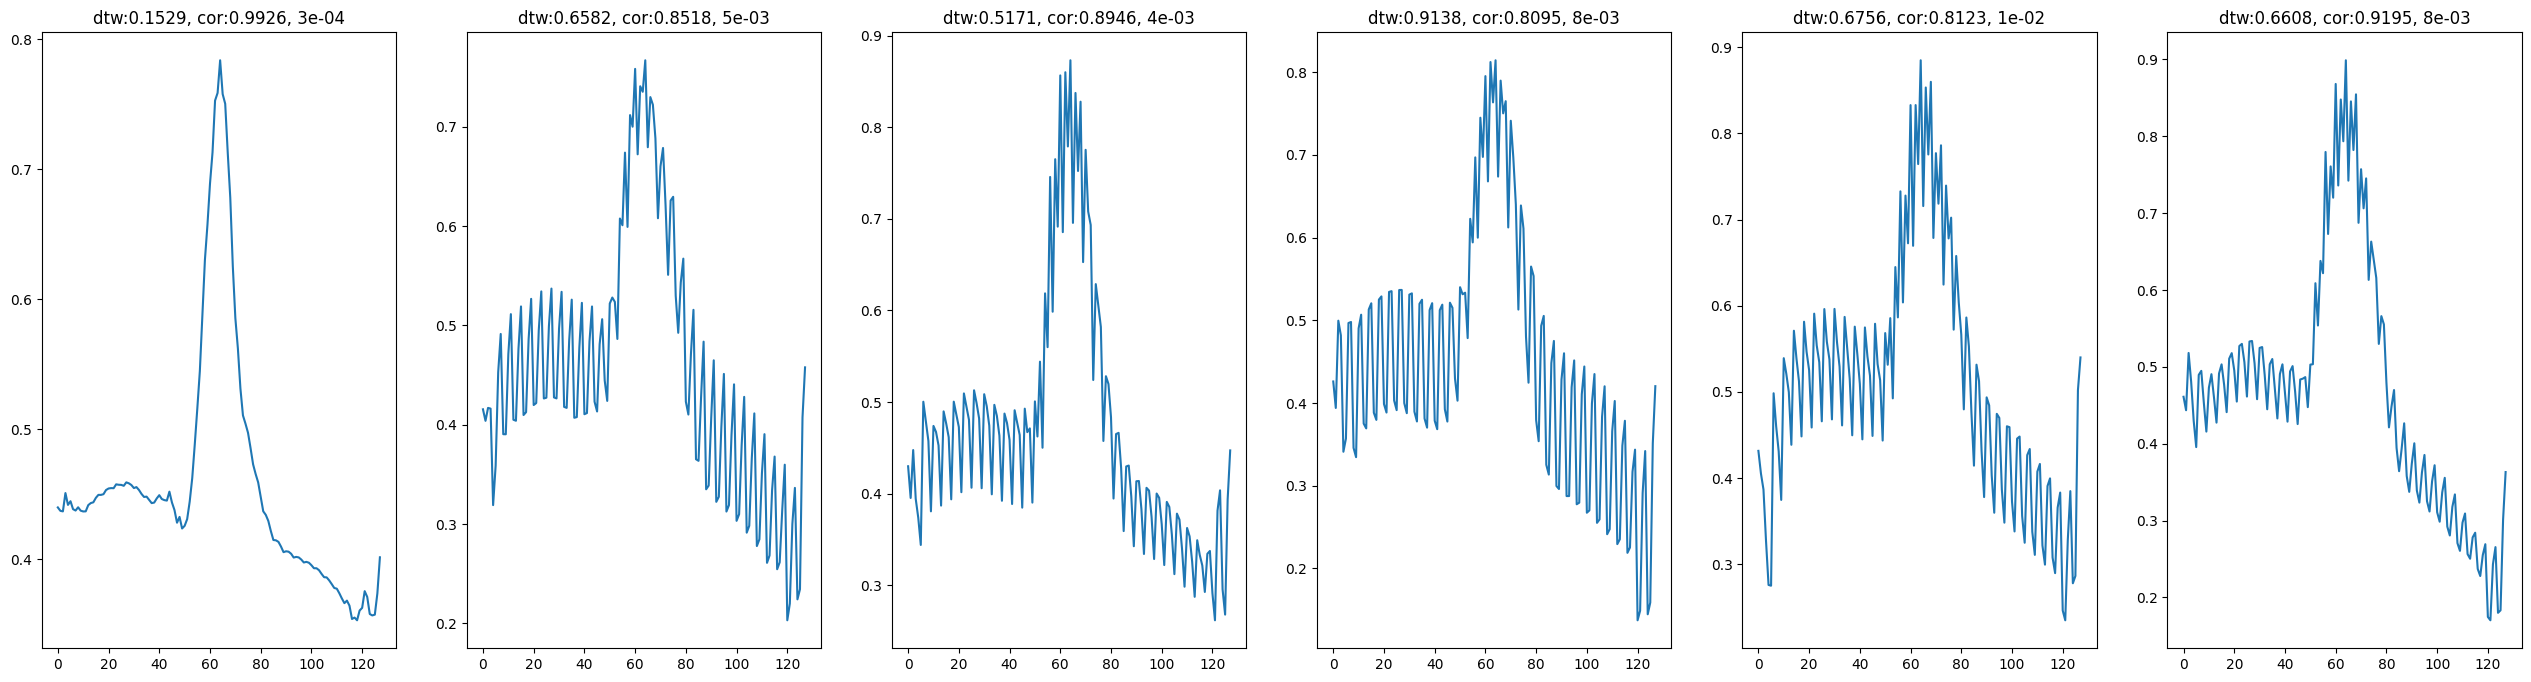

In [12]:
network = train_splitnn(clients, (testset), 'private', 100)
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

Text(0.5, 1.0, 'Reconstructed result 3')

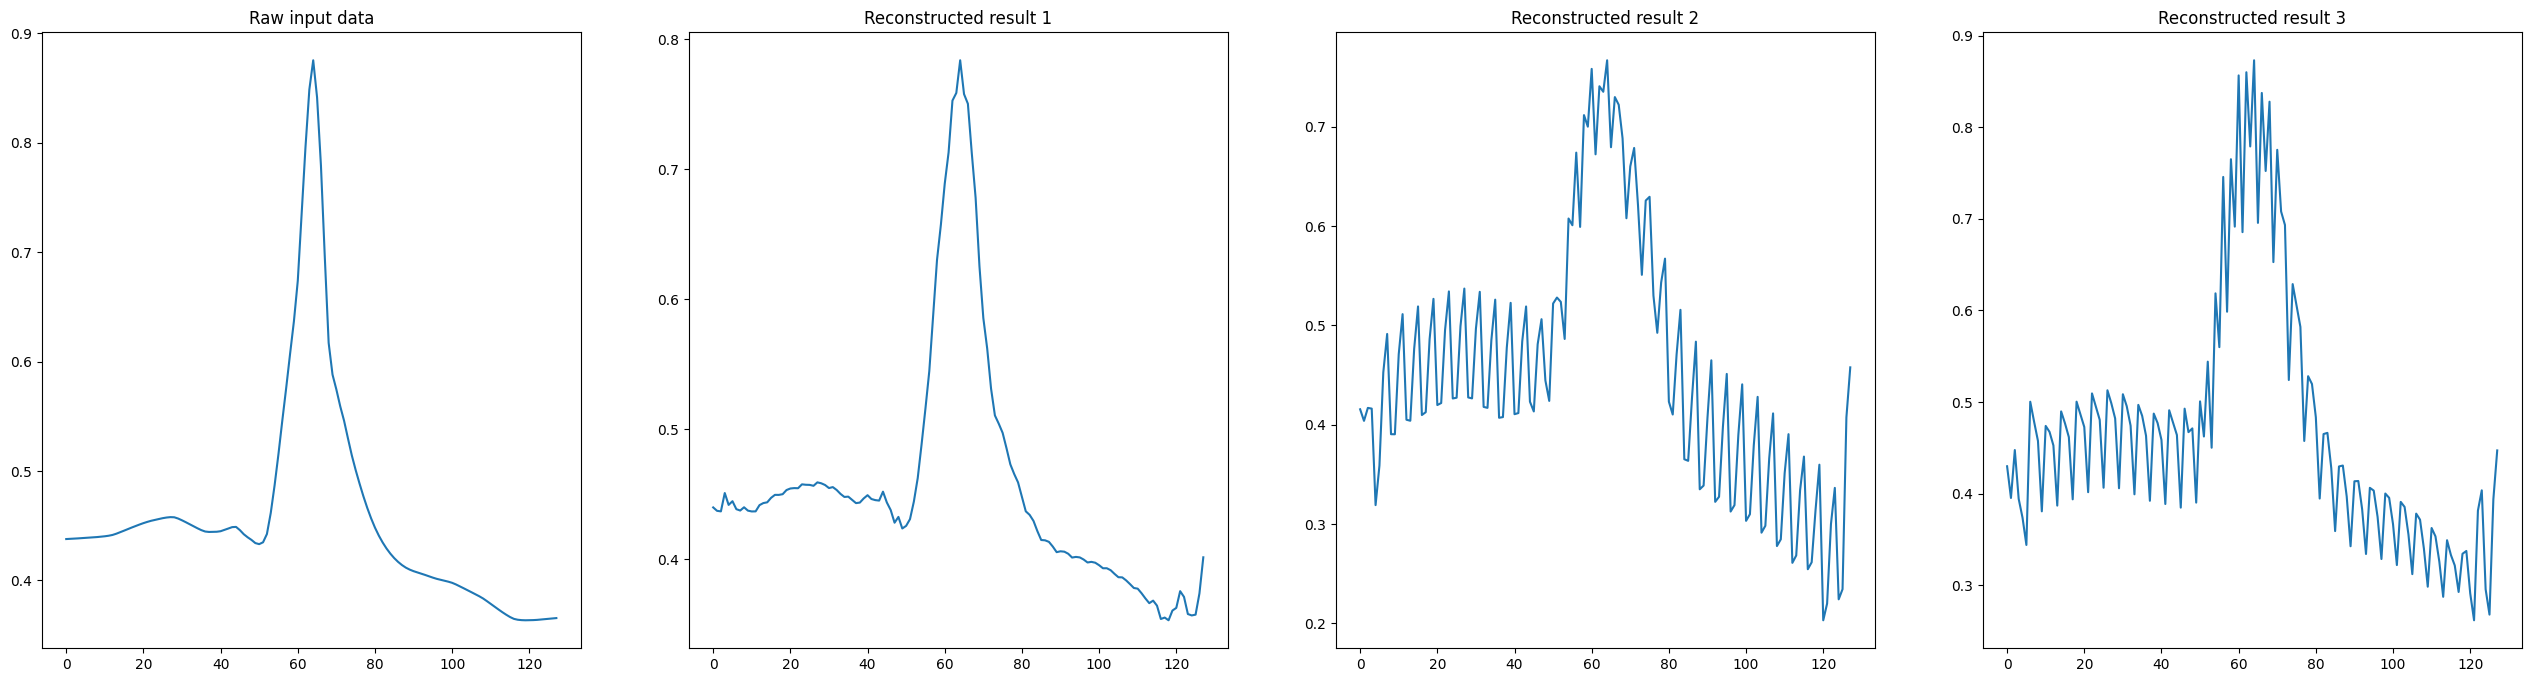

In [17]:
image = next(iter(DataLoader(testset)))[0]
plt.figure(figsize=(32,8))
plt.subplot(1, 4, 1)
plt.plot(image[0,0])
plt.title('Raw input data')
with torch.no_grad():
    network.clients[0].eval(), decoder.eval()
    output = decoder(network.clients[0](image.cuda()))
plt.subplot(1, 4, 2)
plt.plot(output.cpu()[0,0])
plt.title('Reconstructed result 1')
with torch.no_grad():
    network.clients[1].eval(), decoder.eval()
    output = decoder(network.clients[1](image.cuda()))
plt.subplot(1, 4, 3)
plt.plot(output.cpu()[0,0])
plt.title('Reconstructed result 2')
with torch.no_grad():
    network.clients[2].eval(), decoder.eval()
    output = decoder(network.clients[2](image.cuda()))
plt.subplot(1, 4, 4)
plt.plot(output.cpu()[0,0])
plt.title('Reconstructed result 3')